In [43]:
import pandas as pd
pd.set_option('display.max_rows', None)
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
def create_metrics_comparison(results_path="../results"):
    """
    Create a comparison table for different models using all evaluation metrics.
    """
    
    # Metric configuration
    metric_config = {
        'WAPE': {'format': '{:.1f}%'},
        'MAPE': {'format': '{:.1f}%'},
        'R²': {'format': '{:.3f}'},
        'MSE': {'format': '{:.1f}'},
        'RMSE': {'format': '{:.1f}'},
        'MAE': {'format': '{:.0f}'},
    }
    
    # Load results
    dfs = []
    for file_path in glob(os.path.join(results_path, "*average_results.csv")):
        df = pd.read_csv(file_path, index_col=0)
        df['Source_File'] = os.path.basename(file_path)
        dfs.append(df)

    all_models_results = pd.concat(dfs, ignore_index=True)

    # Mapping dictionaries with defined order y agregando Lasso y Ridge
    model_names = {
        'LinearRegression': 'LR',
        'KNeighborsRegressor': 'KNN',
        'RandomForestRegressor': 'RF',
        'XGBRegressor': 'XGB',
        'CatBoostRegressor': 'CAT',
        'LR Lasso': 'Lasso',   
        'LR Ridge': 'Ridge'    
    }
    
    strategy_names = {
        'within_domain': 'Within Domain',
        'cross_domain': 'Cross Domain',
        'all_domain': 'All Domain'
    }

    target_names = {
        'Non-residential EUI (kWh/m2/year)': 'Non-residential',
        'Residential EUI (kWh/m2/year)': 'Residential'
    }

    # Apply mappings
    all_models_results['Strategy'] = all_models_results['Strategy'].map(strategy_names)
    all_models_results['Model'] = all_models_results['Model'].map(model_names)
    all_models_results['Target'] = all_models_results['Target'].map(target_names)

    # Set categorical order for models, incluyendo Lasso y Ridge
    model_order = ['LR', 'Lasso', 'Ridge', 'KNN', 'RF', 'XGB', 'CAT']
    all_models_results['Model'] = pd.Categorical(
        all_models_results['Model'],
        categories=model_order,
        ordered=True
    )

    # Create full detailed table with ordered metrics
    metrics = ['MSE', 'MAE', 'WAPE', 'RMSE', 'R²', 'MAPE']
    
    full_table = pd.pivot_table(
        all_models_results,
        index=['Model', 'Target'],
        columns=['Strategy'],
        values=metrics,
        aggfunc='mean'
    ).sort_index(level=0)

    # Format the values according to metric configuration
    formatted_table = full_table.copy()
    for metric in metrics:
        for strategy in strategy_names.values():
            col = (metric, strategy)
            formatted_table[col] = formatted_table[col].apply(
                lambda x: metric_config[metric]['format'].format(x)
            )
    
    return formatted_table

In [45]:
def create_model_comparison(comparison_table, metric, save_path=None ):
    """
    Create a comparison plot for different models using a specified metric.
    
    Parameters:
    -----------
    comparison_table : pd.DataFrame
        The formatted table from create_metrics_comparison function
    metric : str
        The metric to compare. Options: 'MAPE', 'R²', 'MSE', 'RMSE', 'MAE', 'WAPE'
    save_plot : bool
        Whether to save the plot to file
    save_path : str
        The path where the plot should be saved
    
    Returns:
    --------
    matplotlib.figure.Figure
        The generated plot
    """
    
    # Metric configuration with average labels
    metric_config = {
        'R²': {'format': '%.2f', 'label': 'Avg. R²', 'limits': (-1, 1)},
        'MSE': {'format': '%.0f', 'label': 'Avg. MSE', 'limits': (0, None)},
        'RMSE': {'format': '%.1f', 'label': 'Avg. RMSE', 'limits': (0, None)},
        'MAE': {'format': '%.1f', 'label': 'Avg. MAE', 'limits': (0, None)},
        'WAPE': {'format': '%.1f%%', 'label': 'Avg. WAPE (%)', 'limits': (0, 100)},
        'MAPE': {'format': '%.0f%%', 'label': 'Avg. MAPE (%)', 'limits': (0, 100)}
    }
    
    # Prepare data for plotting
    plot_data = comparison_table[metric].reset_index()
    plot_data = plot_data.melt(id_vars=['Model', 'Target'], 
                              var_name='Strategy', 
                              value_name=metric)
    
    # Convert string percentages to float for plotting
    if metric in ['MAPE', 'WAPE']:
        plot_data[metric] = plot_data[metric].str.rstrip('%').astype(float)
    else:
        plot_data[metric] = plot_data[metric].astype(float)

    # Color palette
    custom_palette = {
        'Non-residential': '#8ab2d5', 
        'Residential': '#98d095'
    }

    # Create plot
    fig, axes = plt.subplots(1, 3, figsize=(22, 8))
    strategies = ['Within Domain', 'Cross Domain', 'All Domain']

    # Calculate dynamic limits
    min_val = plot_data[metric].min()
    max_val = plot_data[metric].max()
    padding = (max_val - min_val) * 0.1
    
    # Set y-axis limits based on metric configuration
    base_min, base_max = metric_config[metric]['limits']
    y_min = base_min if base_min is not None else max(min_val - padding, 0)
    y_max = base_max if base_max is not None else max_val + padding

    for ax, strategy in zip(axes, strategies):
        strategy_data = plot_data[plot_data['Strategy'] == strategy]
        
        # Create bar plot
        bars = sns.barplot(
            data=strategy_data,
            x='Model',
            y=metric,
            hue='Target',
            palette=custom_palette,
            ax=ax
        )
        
        # Add value labels
        for container in bars.containers:
            bars.bar_label(container, 
                          fmt=metric_config[metric]['format'], 
                          padding=5, 
                          fontsize=14)
        
        # Customize appearance
        ax.set_title(f'{strategy}',
                    fontsize=16,
                    pad=20,
                    fontweight='bold')
        ax.set_ylabel(metric_config[metric]['label'], fontsize=14)
        ax.set_ylim(y_min, y_max)
        
        # Remove x-axis label
        ax.set_xlabel('')
        
        # Add baseline
        ax.axhline(y=0, color='red', linestyle='--', alpha=0.3)
        
        # Adjust x-axis labels
        plt.setp(ax.get_xticklabels(), ha='right', fontsize=14)
        
        # Position legend with adjusted position and style
        if strategy == 'Cross Domain':
            legend = ax.legend(bbox_to_anchor=(0.5, -0.05),
                             loc='upper center',
                             ncol=2,
                             fontsize=16)
            # Remove bold from legend labels
            for text in legend.get_texts():
                text.set_fontweight('normal')
        else:
            ax.legend([],[], frameon=False)

    plt.tight_layout()

    # Save plot if requested
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')

    return fig


In [46]:
comparison_table = create_metrics_comparison(results_path="../results")
comparison_table

MAE                                  MAPE  \
Strategy              All Domain Cross Domain Within Domain All Domain   
Model Target                                                             
LR    Non-residential         38           53            26      20.6%   
      Residential             24           31            27      22.2%   
Lasso Non-residential         38           50            23      20.3%   
      Residential             22           25            22      21.0%   
Ridge Non-residential         38           52            26      20.6%   
      Residential             23           28            22      21.6%   
KNN   Non-residential         17           37            22       8.6%   
      Residential             18           28            20      13.7%   
RF    Non-residential         21           28            18      10.0%   
      Residential             17           24            17      13.1%   
XGB   Non-residential         21           30            20       9.8%   
      Residential             20           26            18      14.6%   
CAT   Non-residential         20           34            20       9.9%   
      Residential             19           25            18      15.0%   

                                                        MSE               \
Strategy              Cross Domain Within Domain All Domain Cross Domain   
Model Target                                                               
LR    Non-residential        30.9%         16.1%     3238.7       5037.4   
      Residential            34.1%         23.5%     1047.9       1488.8   
Lasso Non-residential        28.8%         13.3%     3173.9       4596.9   
      Residential            25.8%         18.7%      934.5       1029.9   
Ridge Non-residential        30.5%         14.9%     3230.9       4950.5   
      Residential            31.2%         19.2%     1020.3       1325.5   
KNN   Non-residential        20.8%         11.0%     1132.2       3171.8   
      Residential            24.8%         15.0%      821.3       1306.3   
RF    Non-residential        13.6%          9.0%     1398.4       2324.5   
      Residential            21.0%         12.8%      719.7       1173.2   
XGB   Non-residential        14.4%          9.7%     1846.2       2696.0   
      Residential            19.9%         13.4%     1227.8       1699.4   
CAT   Non-residential        17.6%          9.9%     1576.4       2878.9   
      Residential            19.9%         13.0%      862.0       1266.3   

                                          RMSE                             \
Strategy              Within Domain All Domain Cross Domain Within Domain   
Model Target                                                                
LR    Non-residential        2529.0       46.7         62.6          38.1   
      Residential            2271.8       30.0         38.2          37.8   
Lasso Non-residential        1748.2       46.5         59.4          34.4   
      Residential            1353.9       27.6         30.4          29.5   
Ridge Non-residential        2214.6       46.7         62.0          37.4   
      Residential            1539.4       29.5         35.7          31.1   
KNN   Non-residential        1784.0       27.3         52.5          32.7   
      Residential             951.7       24.1         33.9          25.8   
RF    Non-residential        1334.4       30.0         39.5          29.3   
      Residential             788.5       23.2         30.1          23.6   
XGB   Non-residential        1283.1       32.9         42.6          28.4   
      Residential             951.4       27.9         34.3          26.4   
CAT   Non-residential        1439.7       32.1         45.8          30.1   
      Residential             823.8       25.4         30.6          24.4   

                              R²                                  WAPE  \
Strategy              All Domain Cross Domain Within Domain All Domain   
Model Target       

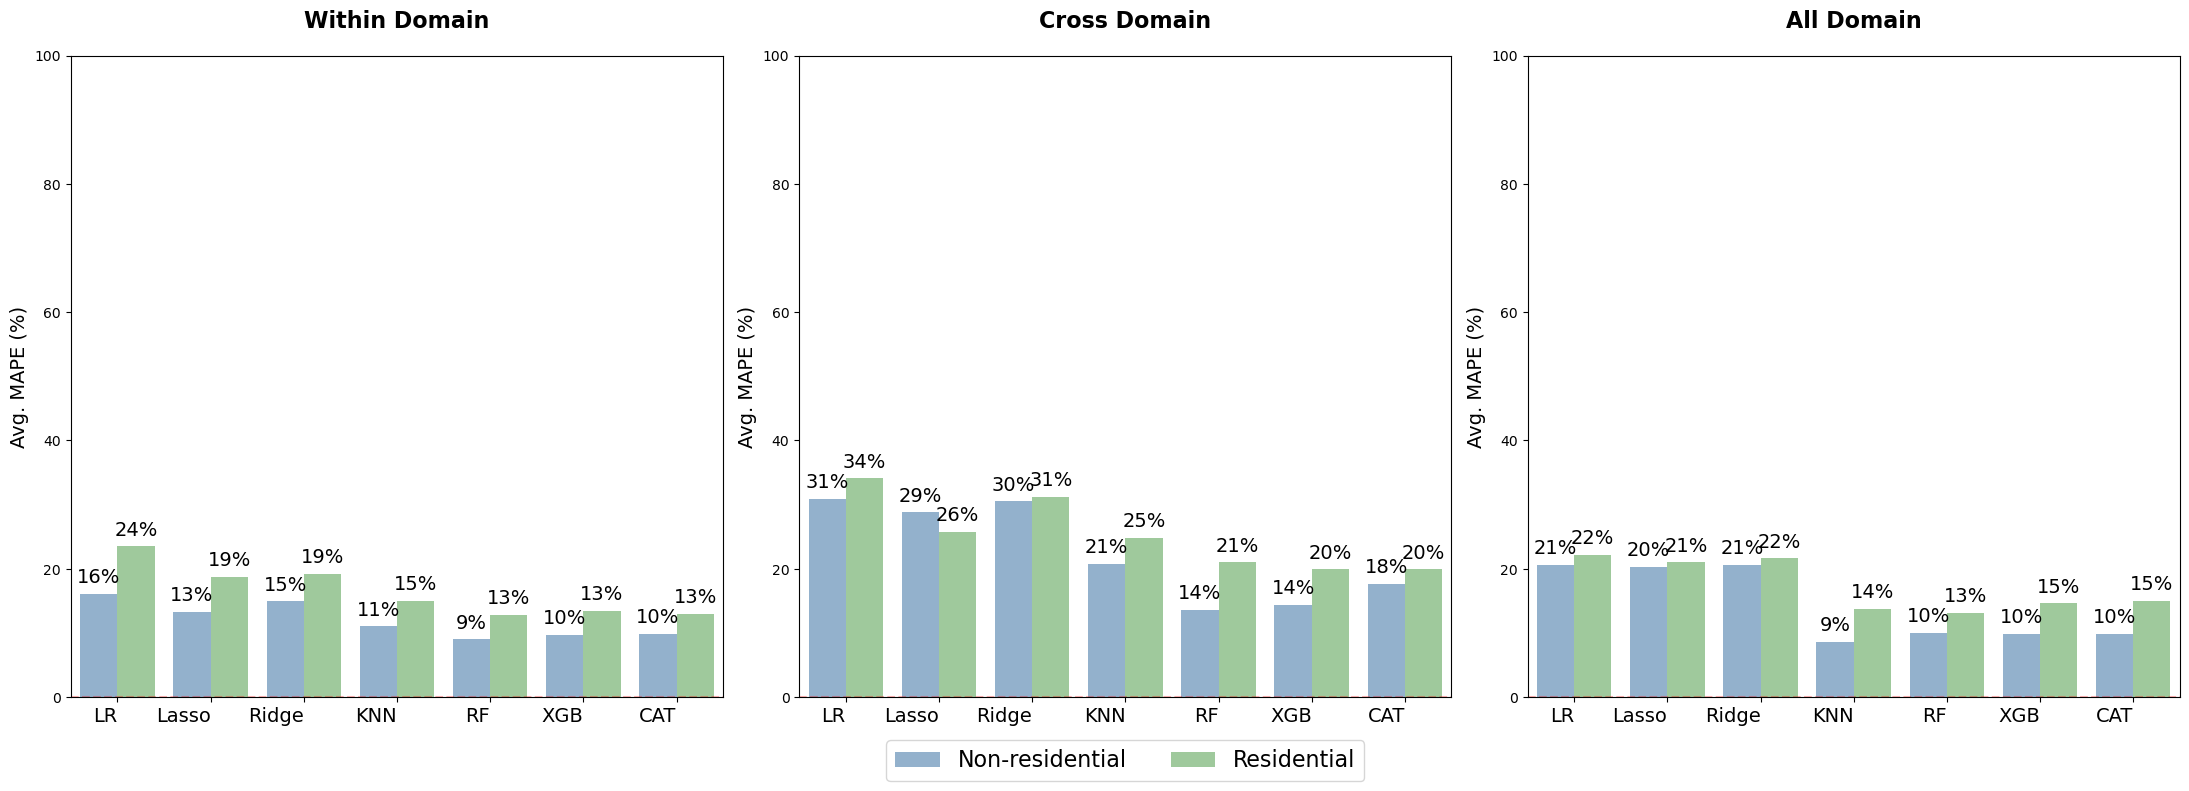

In [47]:
fig = create_model_comparison(comparison_table, metric='MAPE', save_path='../figures/model_plots/00_model_comparison_mape.png')
plt.show()


In [48]:
comparison_table.to_csv("../results/comparison_average_results.csv")

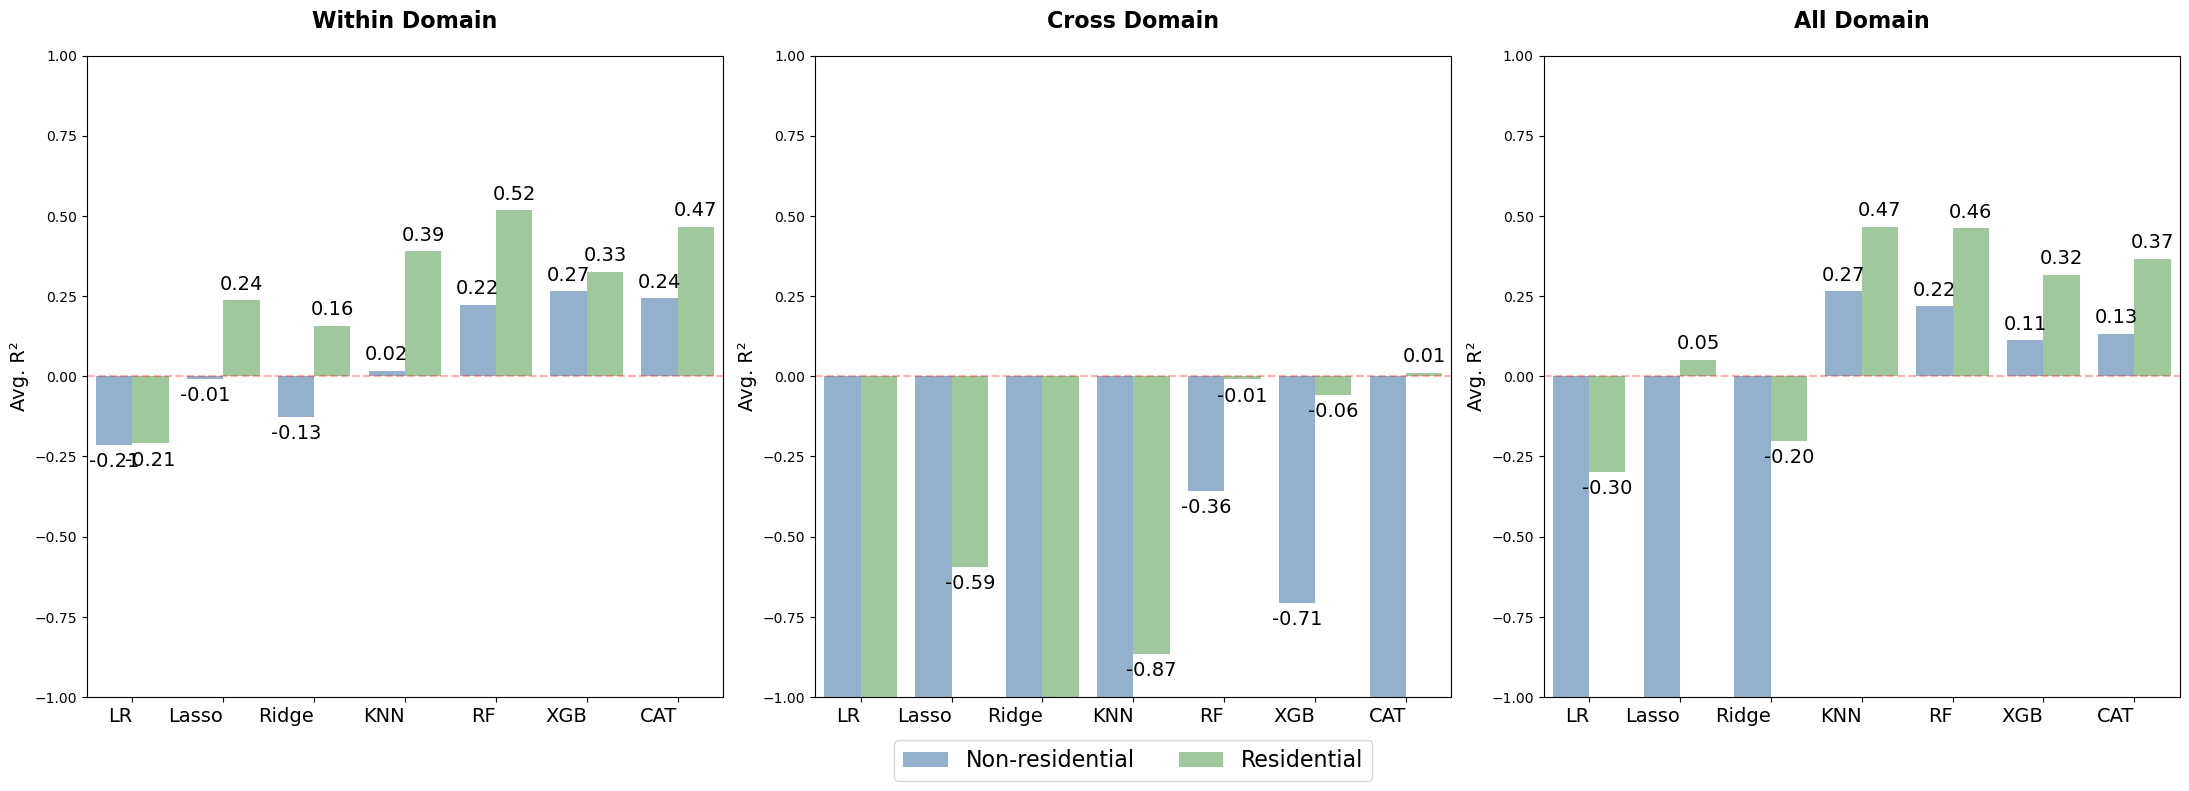

In [49]:
fig = create_model_comparison(comparison_table, metric='R²', save_path='../figures/model_plots/00_model_comparison_r2.png')
plt.show()